In [1]:
import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
# import matplotlib.animation as animation
plt.style.use(['dark_background'])

import numpy as np
import pandas as pd
import os
from tqdm import tqdm

from PIL import Image

from scipy.interpolate import RBFInterpolator
from scipy.signal import resample
from scipy.io import loadmat
from scipy.stats import gaussian_kde

from sklearn.decomposition import PCA


In [25]:
class intervals:
    def __init__(self, array):
        self.i = 0
        self.N = len(array)
        self.array = array
    def __iter__(self):
        return self
    def __next__(self):
        self.i += 1
        if self.i < self.N:
            return self.array[self.i-1], self.array[self.i]
        raise StopIteration

In [85]:
exp_name = "021923B"

symphony_file = f"C:\\Users\\zfj\\data\\{exp_name}\\{exp_name}.h5"
# raw_file = r"C:\Users\zfj\data\021923B\n1337_p1241_00007.tif"
# raw_file = r"C:\Users\zfj\data\021923B\n1337_p1241_00008.tif"
raw_file_root = r"p1141_p1632"
# raw_file_root = r"region2_927nm_00001"

bin_dir =f"C:\\Users\\zfj\\data\\{exp_name}\\func"

# mask_file = f"C:\\Users\\zfj\\data\\{exp_name}\\{exp_name}_region1_stack_red_max_vitreousmasked_cp_masks.png"
mask_file = None# r"C:\Users\zfj\data\071323B\071323B_region2_stack_red_avg_axonsmasked_cp_masks.png"


In [80]:
c = []
b = []
s = []


for f in os.listdir(bin_dir):
    # if not file.startswith(raw_file_root):
    #     continue
    # if file.endswith('chirps.parquet'):
    #     c.append(pd.read_parquet(os.path.join(bin_dir, file)))
    # elif file.endswith('bars.parquet'):
    #     b.append(pd.read_parquet(os.path.join(bin_dir, file)))
    # elif file.endswith('spots.parquet'):
    #     s.append(pd.read_parquet(os.path.join(bin_dir, file)))
    if not os.path.isfile(os.path.join(bin_dir,f)):
        for file in os.listdir(os.path.join(bin_dir, f)):
            if file.endswith('chirps.parquet'):
                c.append(pd.read_parquet(os.path.join(bin_dir, f, file)))
            elif file.endswith('bars.parquet'):
                b.append(pd.read_parquet(os.path.join(bin_dir, f, file)))
            elif file.endswith('spots.parquet'):
                s.append(pd.read_parquet(os.path.join(bin_dir, f, file)))


bars_interp.npy
bars_ti.npy
chirps_interp.npy
chirps_ti.npy
p1141_p1632_00002
['anatomy.bin', 'anatomy_reg.bin', 'bars.parquet', 'chirps.parquet', 'functional.npy', 'ops.npy', 'reg.npy', 'reg_anat_sample.gif', 'spots.parquet']
p1141_p1632_00003
['anatomy.bin', 'anatomy_reg.bin', 'bars.parquet', 'chirps.parquet', 'functional.npy', 'ops.npy', 'reg.npy', 'reg_anat_sample.gif', 'spots.parquet']
p1141_p1632_00004
['anatomy.bin', 'anatomy_reg.bin', 'bars.parquet', 'chirps.parquet', 'functional.bin', 'functional.npy', 'ops.npy', 'reg.npy', 'reg_anat_sample.gif', 'spots', 'spots.parquet']
p1141_p1632_00005
['anatomy.bin', 'anatomy_reg.bin', 'bars.parquet', 'chirps.parquet', 'functional.npy', 'ops.npy', 'reg.npy', 'reg_anat_sample.gif', 'spots.parquet']
p1141_p1632_00006
['anatomy.bin', 'anatomy_reg.bin', 'chirps.parquet', 'functional.npy', 'ops.npy', 'reg.npy', 'reg_anat_sample.gif', 'spots.parquet', 'spots_new.parquet']
p1141_p1632_00007
['anatomy.bin', 'anatomy_reg.bin', 'bars.parquet', 'chi

In [91]:
nt_c = 0
nt_b = 0
nt_s = 0

rois = np.array([], dtype=int)

for chirps in c:
    nt_c += len(np.unique(chirps.trial))
    rois = np.union1d(rois, np.unique(chirps.roi))

resp_c = np.empty((nt_c, len(rois), 500)) * np.nan

for bars in b:
    nt_b += len(np.unique(bars.trial)) // 10
    rois = np.union1d(rois, np.unique(bars.roi))

resp_b = np.empty((nt_b,len(rois),10,100)) * np.nan

for spots in s:
    nt_s += len(np.unique(spots.trial))
    rois = np.union1d(rois, np.unique(spots.roi))

resp_s = np.empty((nt_s,len(rois),50)) * np.nan
cxy = np.empty((nt_s,2)) * np.nan

print(len(rois))

101


In [98]:
from scipy.interpolate import interp1d
spline = lambda x,y,xi: interp1d(x.to_numpy(), y.to_numpy(), bounds_error=False, assume_sorted=True)(xi)

In [99]:
# spline = lambda x,y,xi: RBFInterpolator(x.to_numpy()[:,None], y.to_numpy()[:,None], smoothing=0.5)(xi[:,None])
from scipy.interpolate import CubicSpline
# spline = lambda x,y,xi: CubicSpline(x.to_numpy(),y.to_numpy(),extrapolate=False)(xi)
t = 0
xn_s = np.linspace(-.25, 1, 50)

with tqdm(total=nt_s) as pbar:
    for spots in s:
        epoch = spots.dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','roi']).mean().reset_index()

        for i,trial in enumerate(np.unique(spots.trial)):

            spot = epoch[epoch.trial == trial]
            # theta_i = (bar.theta.iloc[0] / (2*np.pi) * 10).astype(int)
            cxy[t,0] = spot.cx.iloc[0]
            cxy[t,1] = spot.cy.iloc[0]

            for j,roi in enumerate(rois):
                r = spot[spot.roi == roi]

                if len(r) < 32:
                    continue

                f = spline(r.trial_t, r.fluor,xn_s).flatten()            
                bl = np.nanmean(f[xn_s<=0])
                f = (f-bl) / bl

                resp_s[t, j, :] = f
            
            pbar.update()
            t+=1


t = 0
xn_c = np.linspace(-1.75,32.75,500)

with tqdm(total=nt_c*len(rois)) as pbar:
    for chirps in c:        
        for trial in np.unique(chirps.trial):
            tr = chirps[chirps.trial==trial]

            for i,roi in enumerate(rois):
                r = tr[tr.roi == roi].dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','line']).mean()
                if len(r) < 100:
                    pbar.update()
                    continue
                resp_c[t,i,:] = spline(r.trial_t, r.fluor,xn_c).flatten()
                pbar.update()
            
            t += 1

t = 0
xn_b = np.linspace(-.5, 3, 100)

with tqdm(total=nt_b) as pbar:
    for bars in b:
        epoch = bars.dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','roi']).mean().reset_index()
        for i,trial in enumerate(np.unique(bars.trial)):
            bar = epoch[epoch.trial == trial]
            theta_i = (bar.theta.iloc[0] / (2*np.pi) * 10).astype(int)

            for j,roi in enumerate(rois):
                r = bar[bar.roi == roi]

                if len(r) < 32:
                    continue

                f = spline(r.trial_t, r.fluor,xn_b).flatten()            
                bl = np.median(f[xn_b<1.0]) # NOTE: the unusual detrending here
                f = (f-bl) / bl

                resp_b[t, j, theta_i, :] = f
            
            if (i%10) == 9:
                pbar.update()
                t+=1



100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


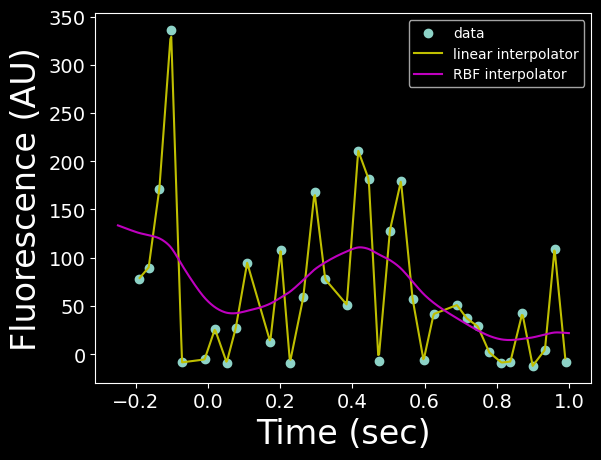

In [142]:
roi = 19
trial = 8664

t = np.linspace(-.25, 1, 500)

# spots = s[0]
# epoch = spots.dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','roi']).mean().reset_index()
spot = epoch[epoch.trial == trial]

x = spot[spot.roi==roi].trial_t
y = spot[spot.roi==19].fluor
plt.scatter(x,y, label='data')

plt.plot(t,spline(x,y,t), c='y', label='linear interpolator')

spline2 = lambda x,y,xi: RBFInterpolator(x.to_numpy()[:,None], y.to_numpy()[:,None], smoothing=0.1)(xi[:,None])
plt.plot(t,spline2(x,y,t), c='m', label='RBF interpolator')
plt.legend()

plt.xlabel('Time (sec)', fontsize=24)
plt.ylabel('Fluorescence (AU)', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# spot[roi==50]
spot
# epoch

plt.savefig(r"C:\Users\zfj\Downloads\smoothing.png", transparent=True)

In [100]:
# np.save(os.path.join(bin_dir,raw_file_root + '_spots_interp.npy'),resp_s)
# np.save(os.path.join(bin_dir,raw_file_root + '_bars_interp.npy'),resp_b)
# np.save(os.path.join(bin_dir,raw_file_root + '_chirps_interp.npy'),resp_c)


# np.save(os.path.join(bin_dir,raw_file_root + '_spots_loc.npy'),cxy)
# np.save(os.path.join(bin_dir,raw_file_root + '_rois.npy'),rois)


# np.save(os.path.join(bin_dir,raw_file_root + '_spots_ti.npy'),xn_s)
# np.save(os.path.join(bin_dir,raw_file_root + '_bars_ti.npy'),xn_b)
# np.save(os.path.join(bin_dir,raw_file_root + '_chirps_ti.npy'),xn_c)

np.save(os.path.join(bin_dir,raw_file_root + '_linear_spots_interp.npy'),resp_s)
np.save(os.path.join(bin_dir,raw_file_root + '_linear_bars_interp.npy'),resp_b)
np.save(os.path.join(bin_dir,raw_file_root + '_linear_chirps_interp.npy'),resp_c)


np.save(os.path.join(bin_dir,raw_file_root + '_linear_spots_loc.npy'),cxy)
np.save(os.path.join(bin_dir,raw_file_root + '_linear_rois.npy'),rois)


np.save(os.path.join(bin_dir,raw_file_root + '_linear_spots_ti.npy'),xn_s)
np.save(os.path.join(bin_dir,raw_file_root + '_linear_bars_ti.npy'),xn_b)
np.save(os.path.join(bin_dir,raw_file_root + '_linear_chirps_ti.npy'),xn_c)


In [62]:
resp_s = np.load(os.path.join(bin_dir,raw_file_root + '_spots_interp.npy'))
resp_b = np.load(os.path.join(bin_dir,raw_file_root + '_bars_interp.npy'))
resp_c = np.load(os.path.join(bin_dir,raw_file_root + '_chirps_interp.npy'))


cxy = np.load(os.path.join(bin_dir,raw_file_root + '_spots_loc.npy'))
rois = np.load(os.path.join(bin_dir,raw_file_root + '_rois.npy'))


xn_s = np.load(os.path.join(bin_dir,raw_file_root + '_spots_ti.npy'))
xn_b = np.load(os.path.join(bin_dir,raw_file_root + '_bars_ti.npy'))
xn_c = np.load(os.path.join(bin_dir,raw_file_root + '_chirps_ti.npy'))


In [18]:
def plot_epochs_for_roi(x, y, roi):
    rr = y[:,roi]
    bl = rr[:,x<0].mean(axis=1, keepdims=True)
    # bl.shape, rr.shape
    rr = (rr - bl)/bl

    plt.figure(figsize=(7,15))
    plt.plot(x,rr.T + np.arange(len(y))[None,:]*3)
    plt.show()

    rrs = rr.copy()
    rrs -= rrs.min(axis=1, keepdims=True)
    rrs /= rrs.max(axis=1, keepdims=True)

    plt.fill_between(x, rrs.T.mean(axis=1) - rrs.T.std(axis=1), rrs.T.mean(axis=1) + rrs.T.std(axis=1), alpha=.3)
    plt.plot(x,rrs.T.mean(axis=1))
    plt.show()

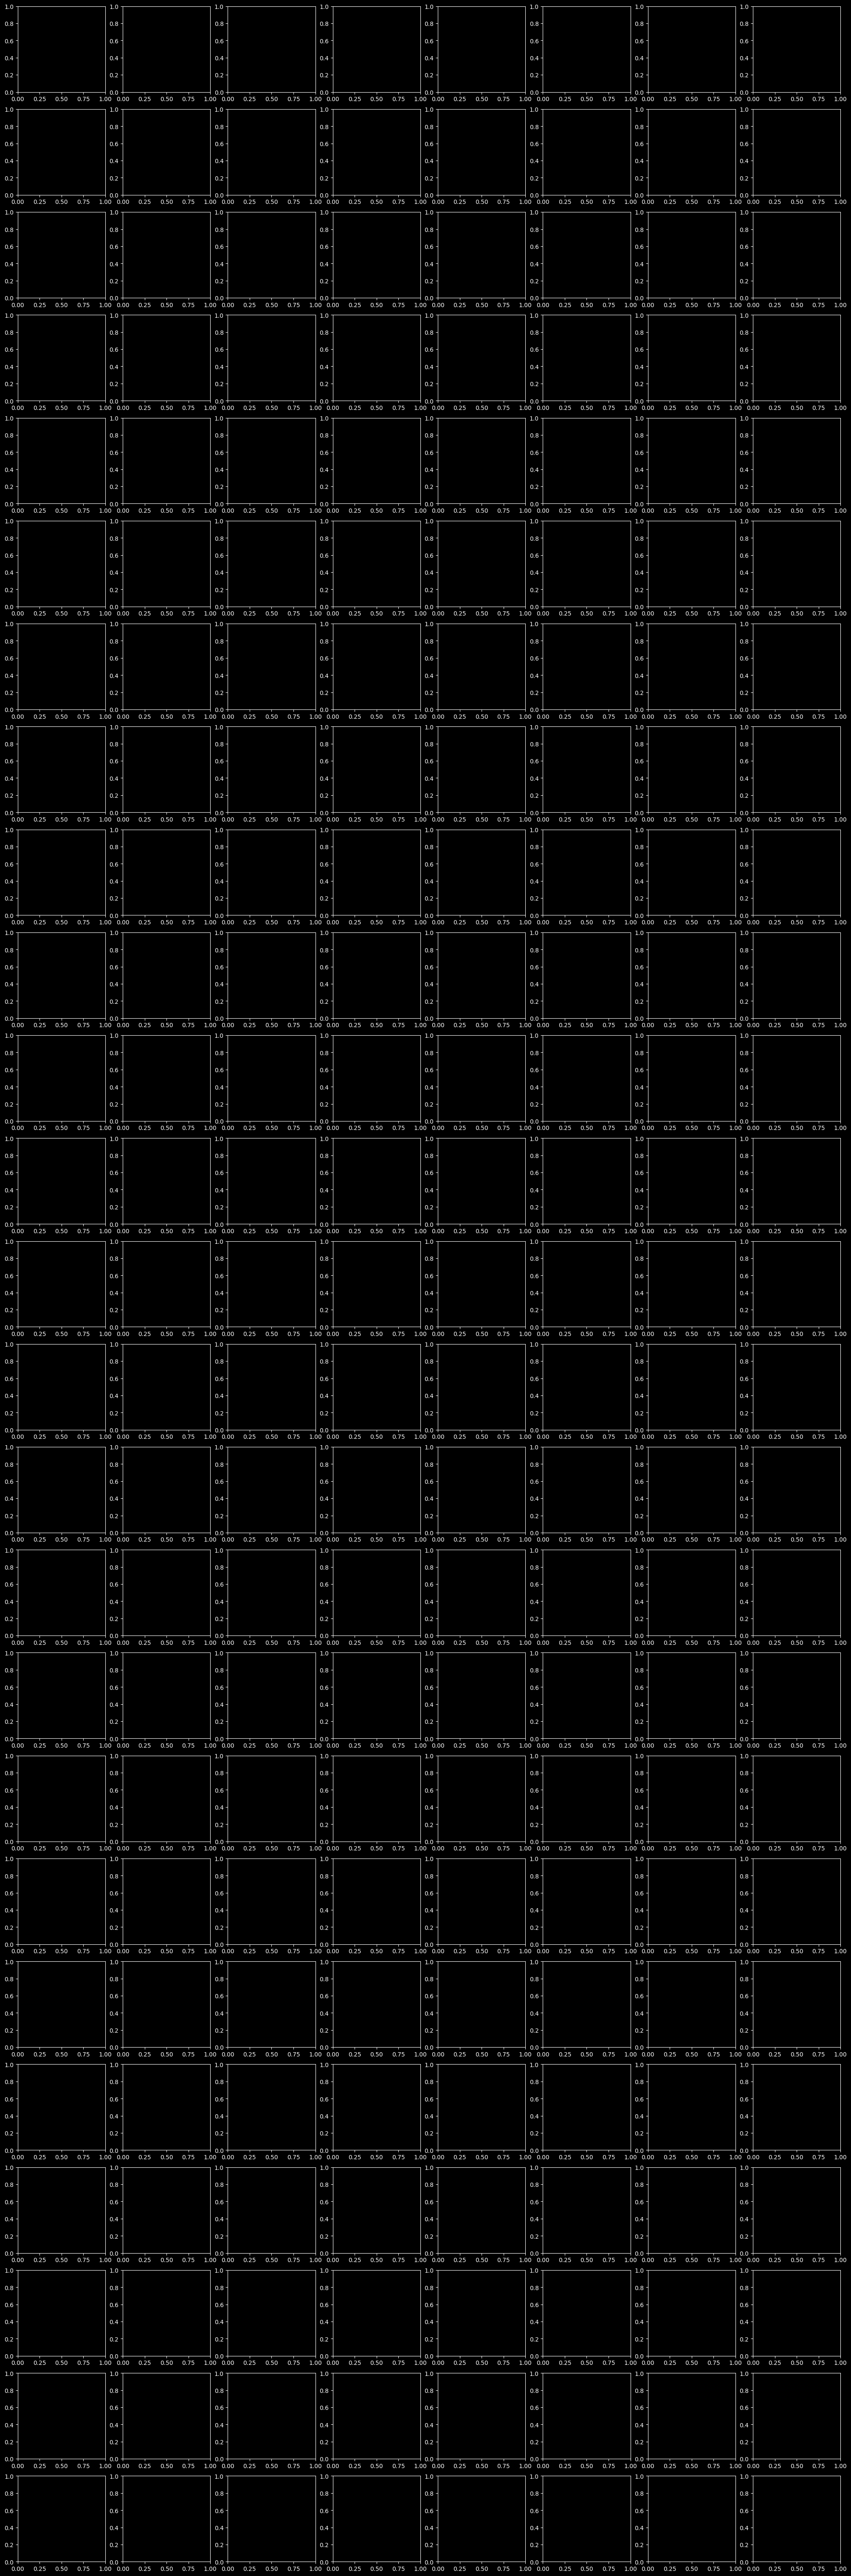

In [59]:
# (588, 104, 50)
_,axs = plt.subplots(np.ceil(resp_s.shape[1]/8).astype(int),8,figsize=(25,np.ceil(resp_s.shape[1]/8)*25/8))
axs = axs.flatten()
for roi in range(resp_s.shape[1]):
    plt.sca(axs[roi])

    # respi = np.asarray([resp_s[ui==i, roi].mean(axis=0) for i in range(len(u))])

    ri = resp_s[:,roi]

    cxyi = cxy[~np.any(np.isnan(ri), axis=1),:]
    ri = ri[~np.any(np.isnan(ri), axis=1)]

    if not len(ri):
        continue
    
    u,ui = np.unique(cxyi,axis=0, return_inverse=True)

    pca = PCA(1)
    pcs = pca.fit_transform(ri)
    
    pcs = [pcs[ui==i].mean() for i in range(len(u))]
    
    low,hi = np.percentile(pcs, [2,98])
    # plt.scatter(cxyi[:,0], cxyi[:,1], c=pcs[:,-1], alpha=.75, edgecolor='none', vmin=low, vmax=hi)
        

    plt.scatter(*u.T, 10, pcs, vmin=low, vmax=hi)
    # plt.scatter(*u.T, 10, c[:,pci])
    # plt.colorbar()
    plt.axis('square')

(-60.0, 60.0)

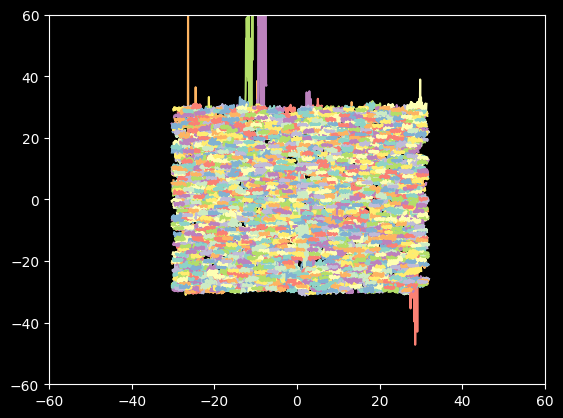

In [87]:
# from scipy.interpolate import CubicSpline
# # spline = lambda x,y,xi: CubicSpline(x.to_numpy()[:,None],y.to_numpy()[:,None],extrapolate=False)(xi[:,None])
# spline = lambda x,y,xi: CubicSpline(x.to_numpy(),y.to_numpy(),extrapolate=False)(xi)
# t = 0
# xn_s = np.linspace(-.25, 1, 50)

# with tqdm(total=nt_s) as pbar:
#     for spots in s:
#         epoch = spots.dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','roi']).mean().reset_index()

#         for i,trial in enumerate(np.unique(spots.trial)):

#             spot = epoch[epoch.trial == trial]
#             # theta_i = (bar.theta.iloc[0] / (2*np.pi) * 10).astype(int)
#             cxy[t,0] = spot.cx.iloc[0]
#             cxy[t,1] = spot.cy.iloc[0]

#             for j,roi in enumerate(rois):
#                 r = spot[spot.roi == roi]

#                 if len(r) < 32:
#                     continue

#                 f = spline(r.trial_t, r.fluor,xn_s).flatten()            
#                 bl = np.mean(f[xn_s<=0])
#                 f = (f-bl) / bl

#                 resp_s[t, j, :] = f
            
#             pbar.update()
#             t+=1

# epoch = s[0].dropna(subset=['fluor','trial_t']).sort_values('trial_t').groupby(['frame','roi']).mean().reset_index()
# epoch

# roi = 16
# # spot = epoch[epoch.trial == trial]
# r = spot[spot.roi == roi] #.sort_values('trial_t')
# f = spline(r.trial_t, r.fluor,xn_s).flatten()            
# # len(spot[spot.roi == 16])


# plt.scatter(spot[spot.roi == roi].trial_t, spot[spot.roi == 16].fluor)
# plt.plot(xn_s, f)

# plt.twinx()
# bl = np.nanmean(f[xn_s<=0])
# f = (f-bl) / bl

# plt.plot(xn_s, f, c='w')
# print(f)

# # f[xn_s<=0]
# # xn_s
# # bl


# # f = spline(r.trial_t, r.fluor,xn_s).flatten()            
# bl = np.nanmean(f[xn_s<=0])
# f = (f-bl) / bl

# resp_s[t, j, :] = f

# plt.plot(resp_s[0,0])
# plt.plot(resp_s[:,0].T)

roi = 16
# u,ui = np.unique(cxyi,axis=0, return_inverse=True)
for i,(x,y) in enumerate(cxy):
    plt.plot(xn_s*2 + x, resp_s[i,roi] + y,)
    # print(x)
# cxy.shape

plt.xlim([-60,60])
plt.ylim([-60,60])



In [35]:
resp_s.shape

(560, 204, 50)

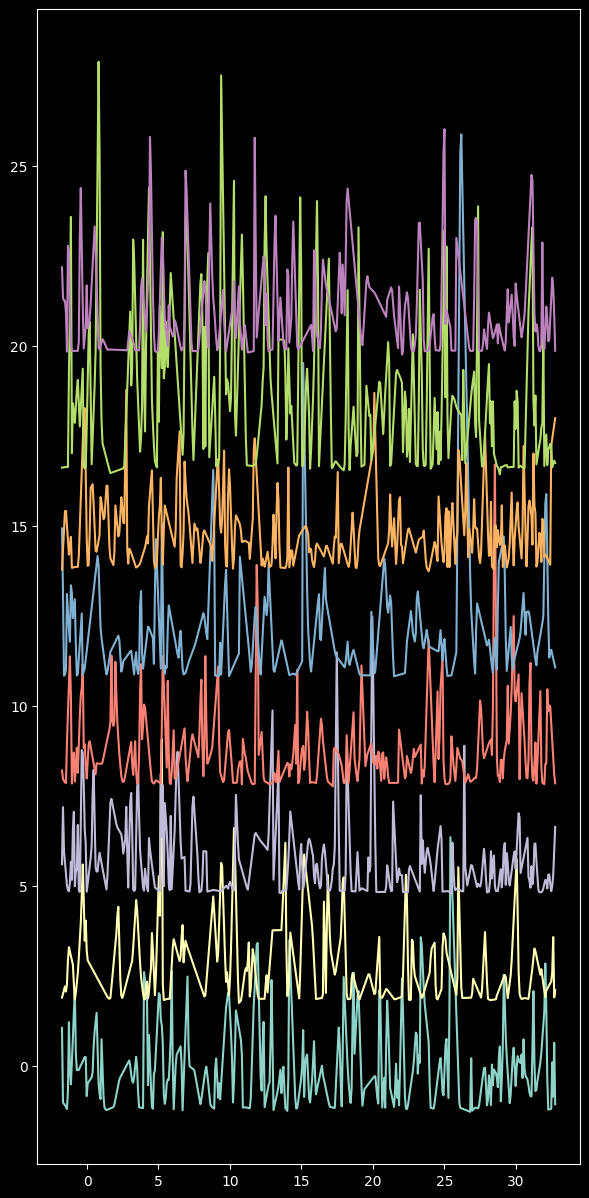

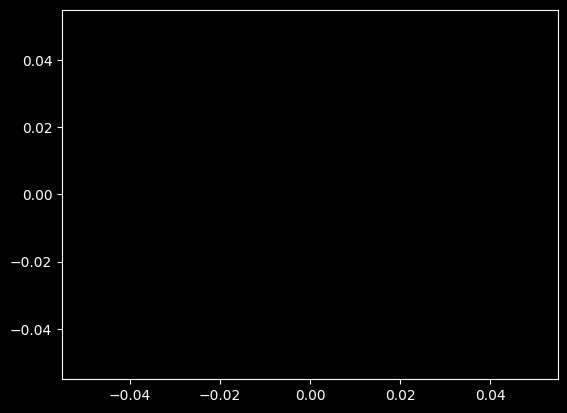

In [101]:
plot_epochs_for_roi(xn_c, resp_c, 100)

In [40]:
resp_c.shape, resp_s.shape

((48, 239, 500), (3360, 239, 50))

In [37]:
def plot_mean_for_rois(x,y):
    rr = y.copy()
    rr -= rr.min(axis=2, keepdims=True)
    rr /= rr.max(axis=2, keepdims=True)
    rr = rr.mean(axis=0)

    # print(rr.shape)
    plt.figure(figsize=(15,resp_c.shape[1]/4))
    plt.plot(x, rr.T + np.arange(rr.shape[0])[None,:]*.3)
    plt.show()

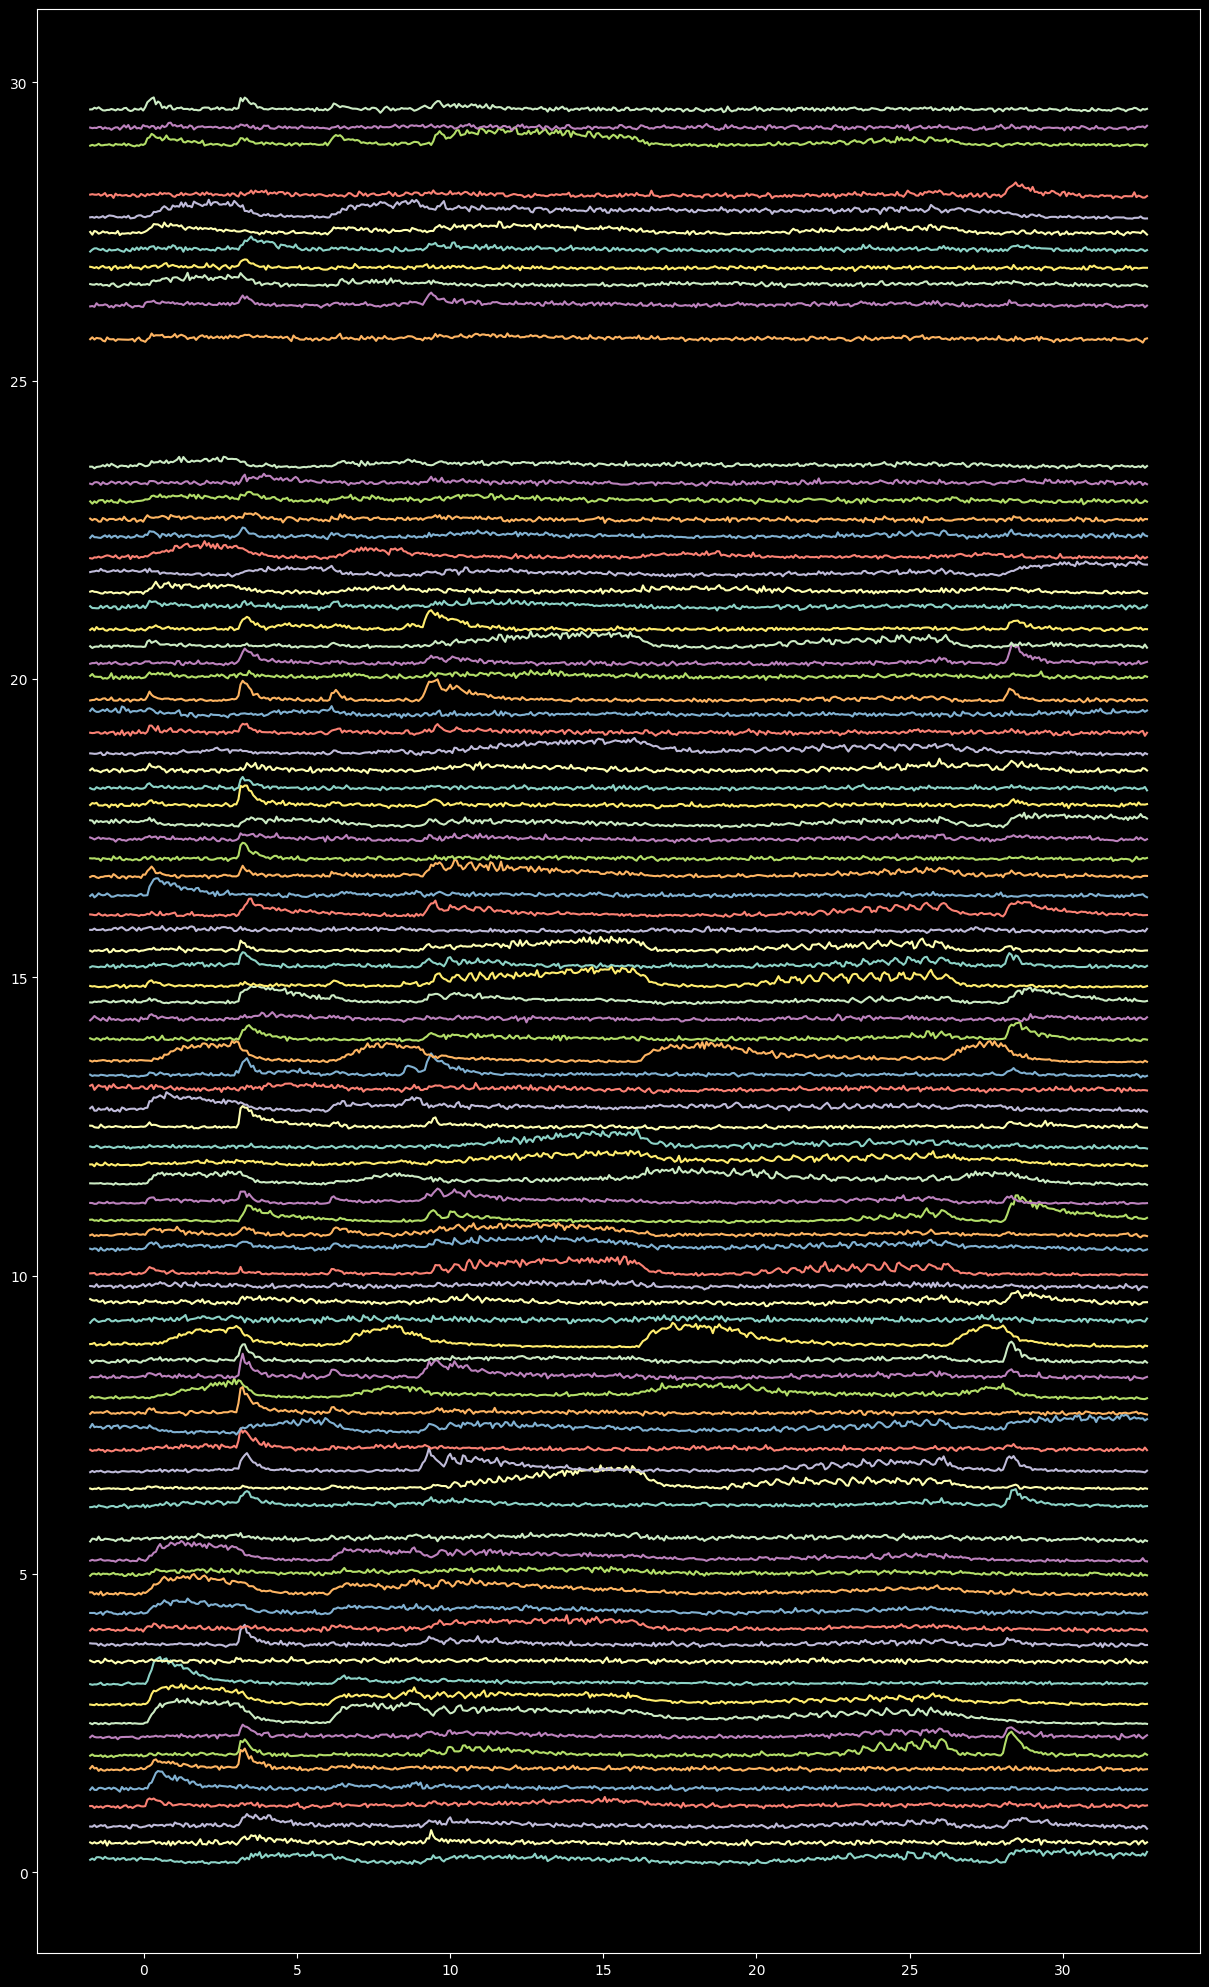

In [102]:
plot_mean_for_rois(xn_c, resp_c)

In [169]:
#calculate DSI using Baden's method
thetas = np.linspace(0,2*np.pi,11)[:10]

dtuning = np.exp(1j*thetas)[None,:]
otuning = np.exp(2j*thetas)[None,:]

dsi = np.empty(len(rois)) * np.nan #DS index
osi = np.empty(len(rois)) * np.nan #OS index
dst = np.empty(len(rois)) * np.nan #DS angle
ost = np.empty(len(rois)) * np.nan #OS angle

dv = np.empty((len(rois), len(thetas))) * np.nan #DS profile

for roi in range(len(rois)):

    respi = np.moveaxis(np.nanmean(resp_b[:,roi],axis=0), -1, -2)
    try:
        u,s,v = np.linalg.svd(respi, full_matrices=False) #fails on NaN

        v0 = v[0,None,:]
        v0 /= np.abs(v0).sum()
        # TODO: double check this
        # Baden says he "normalized by the direction spacing"
        # not sure what exactly he means, but the normalization above is bounded on [0,1] as expected

        dv[roi,:] = v[0,None,:]
        _dsi = dtuning @ v0.T
        dsi[roi] = np.sqrt((_dsi * np.conjugate(_dsi)).sum())
        dst[roi] = np.angle(_dsi)

        _osi = otuning @ v0.T
        osi[roi] = np.sqrt((_osi * np.conjugate(_osi)).sum())
        ost[roi] = np.angle(_osi)

    except np.linalg.LinAlgError:
        pass

C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1690337173.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  dsi[roi] = np.sqrt((_dsi * np.conjugate(_dsi)).sum())
C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1690337173.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  osi[roi] = np.sqrt((_osi * np.conjugate(_osi)).sum())
C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1690337173.py:16: RuntimeWarning: Mean of empty slice
  respi = np.moveaxis(np.nanmean(resp_b[:,roi],axis=0), -1, -2)


In [170]:
# Permutation test on osi,dsi

dsi_d = np.empty((len(rois),1000)) * np.nan
osi_d = np.empty((len(rois),1000)) * np.nan

for k in range(1000):
    respp = np.moveaxis(resp_b,2,1)
    respp = np.random.permutation(respp.reshape((-1,len(rois),100))).reshape(respp.shape)

    #calculate the dsi/osi as above
    for roi in range(len(rois)):
        respi = np.moveaxis(np.nanmean(respp[:,:,roi],axis=0), -1, -2)  
        try:
            u,s,v = np.linalg.svd(respi, full_matrices=False)

            v0 = v[0,None,:]
            v0 /= np.abs(v0).sum()

            _dsi = dtuning @ v0.T
            dsi_d[roi,k] = np.sqrt((_dsi * np.conjugate(_dsi)).sum())

            _osi = otuning @ v0.T
            osi_d[roi,k] = np.sqrt((_osi * np.conjugate(_osi)).sum())
        except np.linalg.LinAlgError:
            pass    

dsi_p = np.asarray([sum(dsi_d[i]>dsi[i])/1000 for i in range(len(rois))])
osi_p = np.asarray([sum(osi_d[i]>osi[i])/1000 for i in range(len(rois))])


C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1377748094.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  dsi_d[roi,k] = np.sqrt((_dsi * np.conjugate(_dsi)).sum())
C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1377748094.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  osi_d[roi,k] = np.sqrt((_osi * np.conjugate(_osi)).sum())
C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\1377748094.py:12: RuntimeWarning: Mean of empty slice
  respi = np.moveaxis(np.nanmean(respp[:,:,roi],axis=0), -1, -2)


In [25]:
def plot_ds_os_indices(i_ds, i_os, t_ds, t_os, p_ds, p_os):

    fig = plt.figure(figsize=(20,14))
    
    # _,axs = plt.subplots(2,2,figsize=(20,14))
    fig.add_subplot(2,2,1)
    plt.scatter(i_ds, p_ds+.001, label='DSi')
    plt.scatter(i_os, p_os+.001, label='OSi')
    plt.hlines(.05,-.05,1.05,'w',linestyle='--')

    plt.xlim(-.05, 1.05)
    plt.legend()
    plt.xlabel('Direction / Orientation Selectivity index')
    plt.ylabel('Permutation p value')
    plt.yscale('log')

    fig.add_subplot(2,2,2)
    plt.scatter(dsi[(p_ds<=.05) & (p_os >.05)],osi[(p_ds<=.05) & (p_os >.05)], label='DS')
    plt.scatter(dsi[(p_ds>.05) & (p_os <=.05)],osi[(p_ds>.05) & (p_os <=.05)], label='OS')
    plt.scatter(dsi[(p_ds<=.05) & (p_os <=.05)],osi[(p_ds<=.05) & (p_os <=.05)], c='w', label='DS+OS')
    plt.scatter(dsi[(p_ds>.05) & (p_os >.05)],osi[(p_ds>.05) & (p_os >.05)], edgecolors='w', facecolors = 'none', label='n.s.')

    plt.xlabel('Direction Selectivity index')
    plt.ylabel('Orientation Selectivity index')

    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.legend()

    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax = fig.add_subplot(2,2,3,projection='polar')    
    ax.hist((np.pi + t_ds[(p_ds<=.05) & (i_ds>=.2)]) % (2*np.pi), np.linspace(0,2*np.pi,11))
    ax.set_ylim(0,6)
    ax.set_xticks(np.linspace(0,2*np.pi,11)[:-1])
    ax.tick_params(axis='x', colors='k')
    ax.set_yticks(np.arange(1,7))
    ax.set_title('Preferred Direction')
    ax.spines['polar'].set_visible(False)
    ax.tick_params(axis='y', colors='k', which='minor')
    ax.grid(color='k')
    ax.set_rlabel_position(54)
    ax.set_yticks(np.arange(1,7)+0.2, minor=True)
    ax.set_yticklabels([f"{i+1}" for i in range(1,7)], va='bottom', minor=True, color='k')
    ax.set_yticklabels([f"" for i in range(1,7)], va='bottom', minor=False, color='k')


    ax = fig.add_subplot(2,2,4,projection='polar')
    ax.hist(np.concatenate(((np.pi+t_os[(p_os<=.05) & (i_os>=.2)])%(2*np.pi), (np.pi*2 + t_os[(p_os<=.05) & (i_os>=.2)]) % (2*np.pi))), np.linspace(0,2*np.pi,11), color = cs[1])
    ax.set_ylim(0,6)
    ax.set_xticks(np.linspace(0,2*np.pi,11)[:-1])
    ax.tick_params(axis='x', colors='k')
    ax.set_yticks(np.arange(1,7))
    ax.set_title('Preferred Orientation')
    ax.spines['polar'].set_visible(False)
    ax.tick_params(axis='y', colors='k', which='minor')
    ax.grid(color='k')
    ax.set_rlabel_position(54)
    ax.set_yticks(np.arange(1,7)+0.2, minor=True)
    ax.set_yticklabels([f"{i+1}" for i in range(1,7)], va='bottom', minor=True, color='k')
    ax.set_yticklabels([f"" for i in range(1,7)], va='bottom', minor=False, color='k')

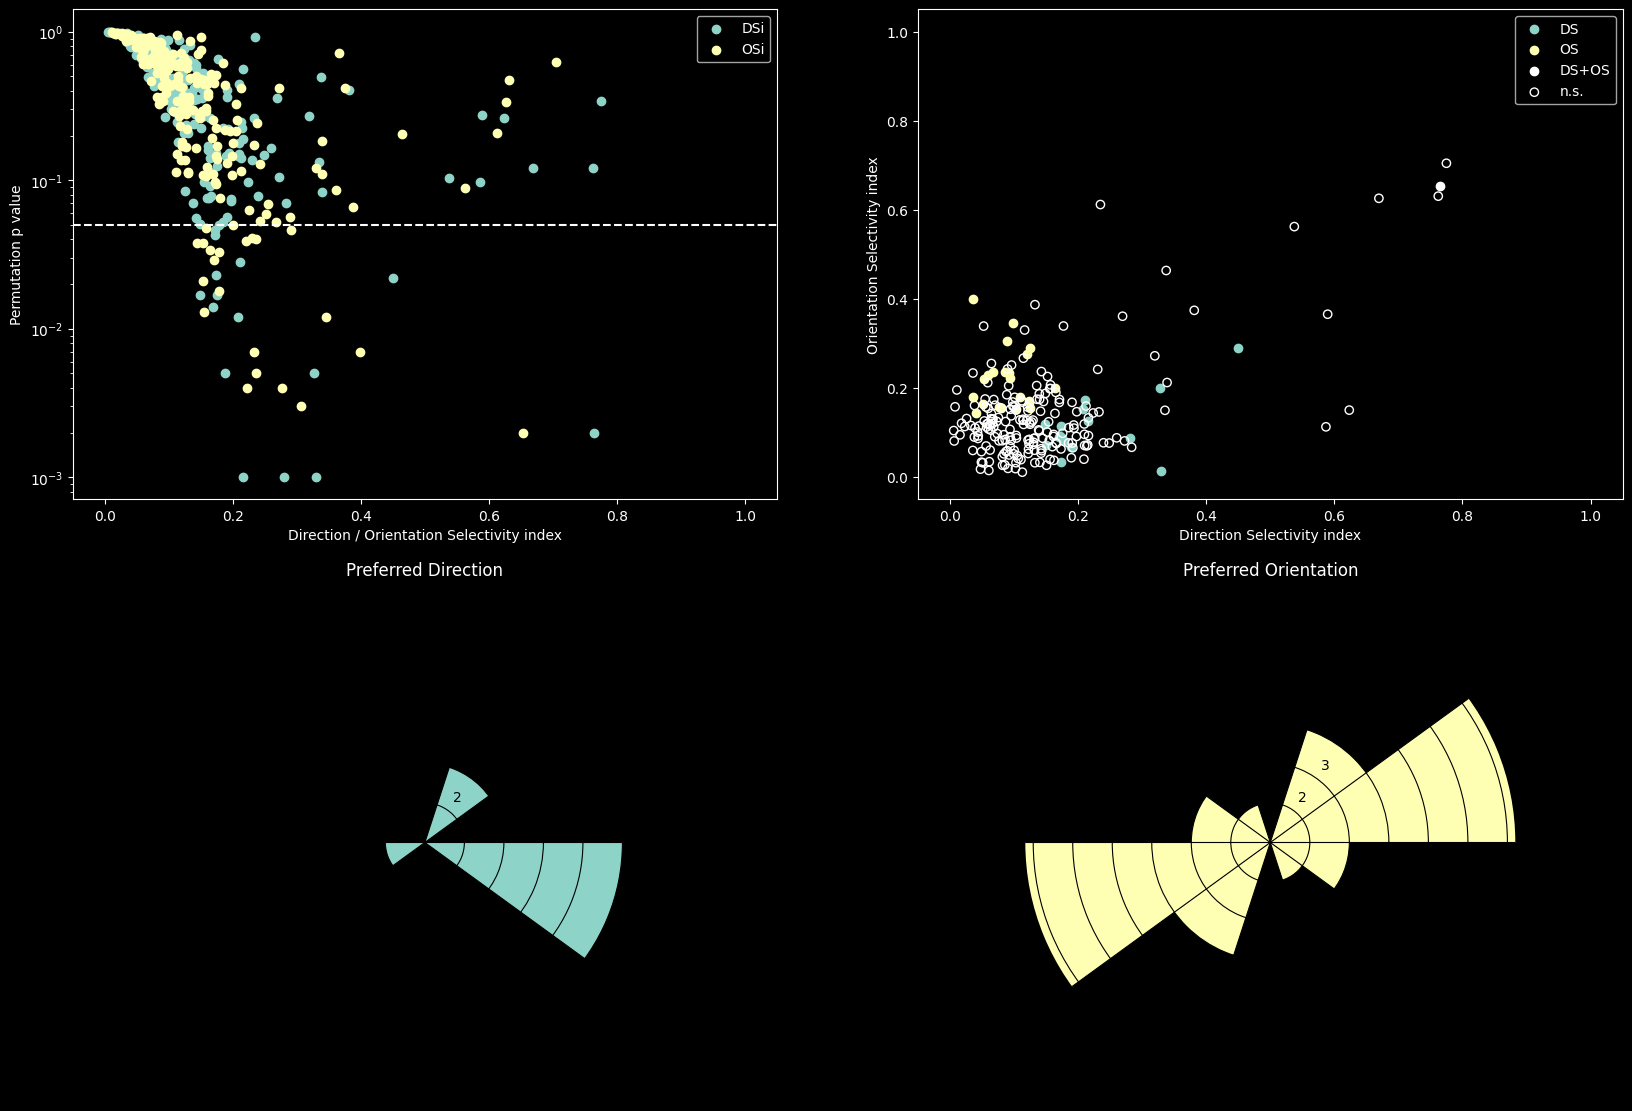

In [175]:
plot_ds_os_indices(dsi,osi,dst,ost,dsi_p,osi_p)

In [176]:
#Load the data from Baden et al 2016

M = loadmat("BadenEtAl_RGCs_2016_v1.mat")
ci = M['cluster_idx'].flatten() - 1
clust_avg = np.array([M['chirp_avg'][:, ci==i].mean(axis=1) for i in range(49)])

dsc = np.array([2, 17,18,19, 22, 35, 36]) - 1 #DS clusters
dsci = np.isin(np.arange(49), dsc)
ndsc = np.nonzero(~dsci)[0]

#cluster names
cnames = [
    'OFF local, OS',
    'OFF DS',
    'OFF step',
    'OFF slow',
    'OFF slow',
    'OFF alpha sust.',
    'OFF alpha sust.',
    'OFF alpha sust.',
    '(ON-)OFF "JAM-B" mix',
    'OFF sust.',
    'OFF alpha trans.',
    'OFF alpha trans.',
    'OFF "mini" alpha trans.',
    'ON-OFF local-edge "W3"',
    'ON-OFF local',
    'ON-OFF local',
    'ON-OFF DS 1',
    'ON-OFF DS 1',
    'ON-OFF DS 2',
    '(ON-)OFF local, OS',
    'ON step',
    'ON DS trans.',
    'ON local trans., OS',
    'ON local trans., OS',
    'ON local trans., OS',
    'ON trans.',
    'ON trans.',
    'ON trans., large',
    'ON high freq.', 
    'ON low freq.',
    'ON sust.',
    'ON sust.',
    'ON "mini" alpha',
    'ON alpha',
    'ON DS sust. 1',
    'ON DS sust. 2',
    'ON slow',
    'ON contrast suppr.',
    'ON contrast suppr.',
    'ON DS sust. 3',
    'ON local sust., OS',
    'OFF suppr. 1',
    'OFF suppr. 1',
    'OFF suppr. 1',
    'OFF suppr. 1',
    'OFF suppr. 1',
    'OFF suppr. 2',
    'OFF suppr. 2',
    'OFF suppr. 2',
]
len(cnames)

49

In [177]:
#normalize the chirp trials, then average, renormalize, and resample
ra = resp_c[:,:,xn_c<30].copy()
ra -= ra.min(axis=-1, keepdims=True)
ra /= ra.max(axis=-1, keepdims=True)
ra = ra.mean(axis=0)

ra -= ra.min(axis=-1, keepdims=True)
ra /= ra.max(axis=-1, keepdims=True)
ra = resample(ra, 244, axis=-1)

#normalize the Baden chirps
ca = clust_avg[:, 5:].copy()
ca -= ca.min(axis=1, keepdims=True)
ca /= ca.max(axis=1, keepdims=True)

cmatch = np.empty(len(rois)) * np.nan
for i in range(len(rois)):
    if any(np.isnan(ra[i])):
        continue
    if dsi_p[i] >.05: # not DS
        cmatch[i] = ndsc[np.argmax(np.corrcoef(ra[i], ca[~dsci])[0,1:])]
    else:
        cmatch[i] = dsc[np.argmax(np.corrcoef(ra[i], ca[dsci])[0,1:])]

In [29]:
def plot_type_histogram(match, names):
    plt.figure(figsize=(20,7))
    plt.hist(match, np.arange(50))
    plt.xticks(np.arange(49)+.5, names, rotation=90)

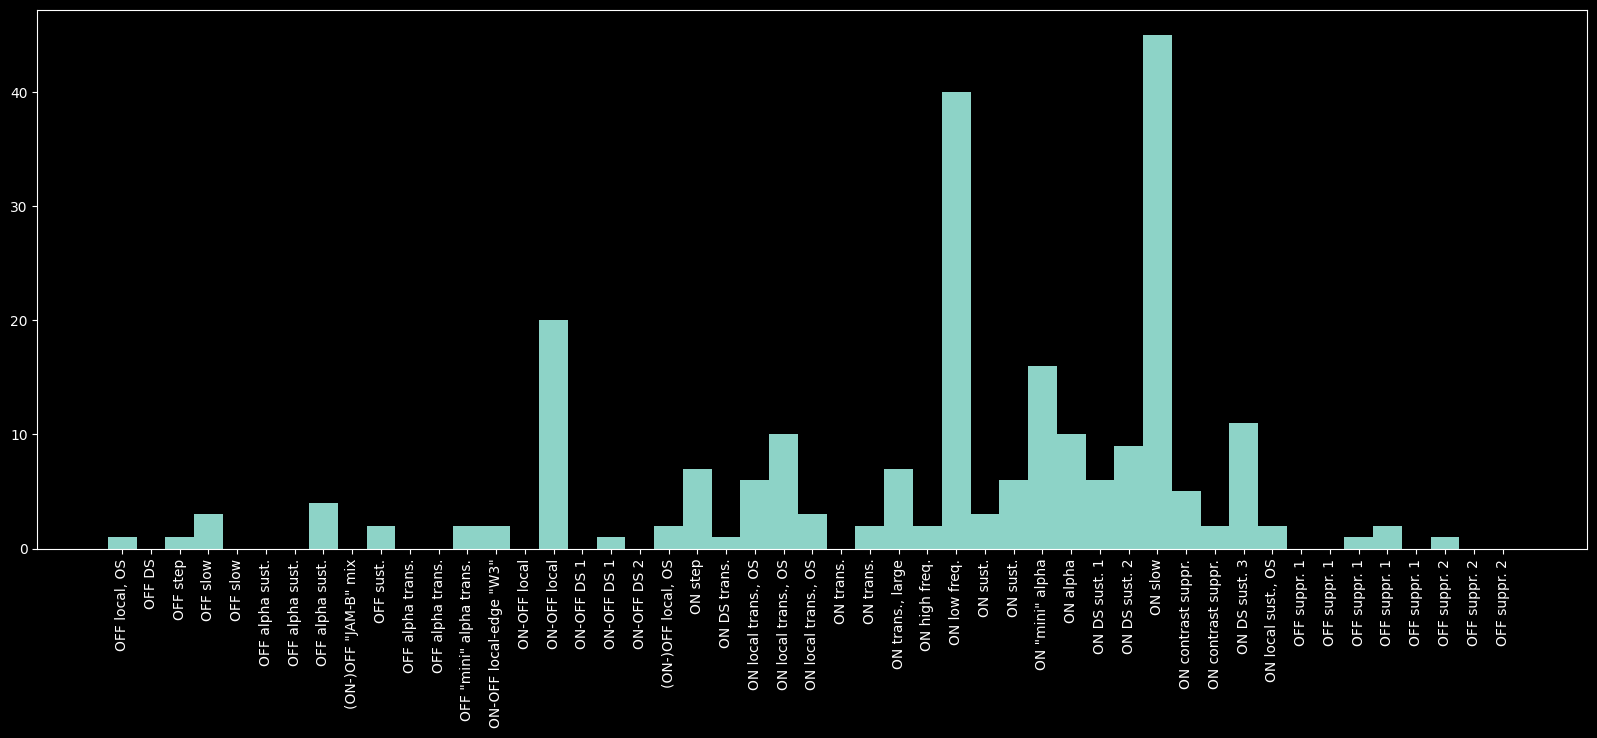

In [178]:
plot_type_histogram(cmatch,cnames)

In [179]:
mask = np.asarray(Image.open(mask_file).getdata()).reshape((512,512)) #TODO: account for mask file shape
mask2 = np.empty_like(mask, dtype=float) * np.nan

for i,roi in enumerate(rois):
    if np.isnan(cmatch[i]):
        continue
    thiscol = M['c2g'][0,int(cmatch[i])]
    mask2[mask==roi] = thiscol

In [32]:
def plot_rois(mask1, mask2, rois, match):
    colors_m = np.random.rand(46,3) #TODO: seed, for consistent coloring
    colors = ListedColormap(colors_m,'randcols', 46)

    
    qx,qy = np.meshgrid(np.arange(512),np.arange(512))

    plt.imshow(mask2, cmap=colors, interpolation='none')
    plt.clim(0,46)
    plt.xticks([])
    plt.yticks([])
    for i,roi in enumerate(rois):
        if np.isnan(match[i]):
            continue        
        x = qx[mask1==roi].mean()
        y = qy[mask1==roi].mean()    

        if colors_m[thiscol].mean() > .5:
            txtcol = '#353535'
        else:
            txtcol = 'w'
        
        plt.text(x,y,i, ha='center', va='center', color=txtcol)

C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\2757855602.py:15: RuntimeWarning: Mean of empty slice.
  x = qx[mask1==roi].mean()
c:\Users\zfj\anaconda3\envs\func_img\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\2757855602.py:16: RuntimeWarning: Mean of empty slice.
  y = qy[mask1==roi].mean()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finit

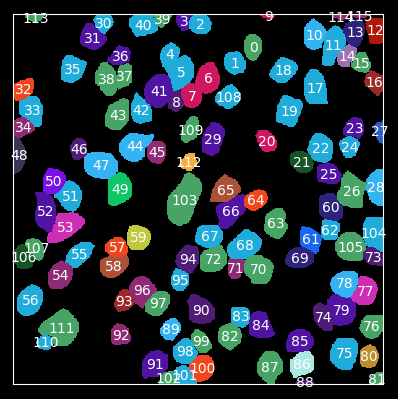

In [182]:
plot_rois(mask, mask2, rois, cmatch)

In [34]:
def chirp_pattern(intensity, sf = 60):
   sf = int(sf)
   chirp = np.concatenate((
        np.zeros(2*sf), #pre time
        np.ones(3*sf), #positive step
        np.zeros(3*sf), #negative time
        np.ones(2*sf) * 0.5, #inter time
        
        -np.sin(2*np.pi*np.linspace(0,8/sf,sf*8).cumsum() + np.pi)/2 + .5, # freq chirp

        np.ones(2*sf) * 0.5, #inter time
        -np.linspace(0,1,sf*8)*np.sin(2*np.pi*2*np.arange(1/sf, 8+(1/sf), 1/sf) + np.pi)/2 + .5, # amp chirp
      

        np.ones(2*sf) * 0.5, #inter time
        np.zeros(5*sf), #tail time
   )) 

   return np.round(chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)
#    return (chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)

In [40]:
resp_s.shape

(1708, 116, 50)

In [338]:
#plot an example cell
# RF map, chirp response, DS

if not os.path.exists(os.path.join(bin_dir, 'rois')):
    os.mkdir(os.path.join(bin_dir, 'rois'))

if not os.path.exists(os.path.join(bin_dir, 'rois', raw_file_root)):
    os.mkdir(os.path.join(bin_dir, 'rois', raw_file_root))

X,Y = np.meshgrid(np.linspace(-30,30,50), np.linspace(-30,30,50))

for roi in range(resp_s.shape[1]):
# roi = 56 #0, 63, 56

    ri = resp_s[:,roi]
    cxyi = cxy[~np.any(np.isnan(ri), axis=1),:]
    ri = ri[~np.any(np.isnan(ri), axis=1)]

    
    u,ui = np.unique(cxyi, axis=0, return_inverse=True)
    
    fig = plt.figure(figsize=(30,30))

    if ri.size >= 50:
        pca = PCA(3)
        # pcs = pca.fit_transform(ri.T)
        pcs = pca.fit_transform(np.asarray([ri[ui==i].mean(axis=0) for i in range(len(u))]).T)
        
        # pcr = np.asarray([np.nanmean(pca.components_[0,ui == i]) for i in range(len(u))])
        pcr = pca.components_[0]

        low,hi = np.percentile(pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), [2,98])


        fig.add_subplot(3,3,1)
        plt.scatter(*u.T, c=pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), alpha=.75, edgecolor='none', vmin=low, vmax=hi)
        plt.axis('square')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        plt.title('Spot responses')


        fig.add_subplot(3,3,2)
        plt.plot(xn_s, pcs)
        plt.title('Top 3 PCs')
        plt.xlabel('Time (seconds)')
        plt.axvline(0,0,1)
        plt.axvline(.25,0,1)

        fig.add_subplot(3,3,3)
        plt.plot(pca.components_.T)
        plt.title('Loadings vs. time')
        plt.xlabel('Epoch #')



        ###### response map
        fig.add_subplot(3,3,4)

        null = gaussian_kde(u.T, weights=np.ones(len(u))/len(u))
        nZ = null.evaluate([X.flatten(), Y.flatten()])
        w = pcr * np.sign(pcr[np.argmax(np.abs(pcr))])
        w = np.clip(w, low, hi) - low
        w /= w.sum()
        kern = gaussian_kde(u.T, weights = w)

        Z = kern.evaluate([X.flatten(), Y.flatten()])
        plt.imshow((Z-nZ).reshape(X.shape), origin='lower', extent=[-30,30,-30,30], cmap='inferno')

        plt.clim((kern.evaluate(u.T) - null.evaluate(u.T)).min(), (kern.evaluate(u.T) - null.evaluate(u.T)).max())
        plt.axis('off')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        plt.title('RF map')

    else:
        fig.add_subplot(3,1,1)
        plt.axis('off')


    ###### bars response
    fig.add_subplot(3,3,5)
    thetas = np.linspace(0,2*np.pi,11)[:10]
    scale = 1.5
    rad = 6
    for th in range(10):
        plt.fill_between(rad*np.cos(thetas[th] + np.pi) + np.array([1,2]), rad*np.sin(thetas[th] + np.pi)-.5, rad*np.sin(thetas[th] + np.pi)+2, color='#4E2A84AF')
        plt.plot(xn_b + rad*np.cos(thetas[th] + np.pi), resp_b[:,roi,th,:].mean(axis=0).T*scale + rad*np.sin(thetas[th] + np.pi), 'w', linewidth=2)
    # plt.axis('square')
    plt.xlim(-rad - 1, rad + 3.5)
    plt.ylim(-rad - scale + 1, rad + scale + .5)
    plt.axis('off')
    plt.title('Moving bar response')

    ax = fig.add_subplot(3,3,5,projection='polar')
    ax.axis('off')

    ax.set_position([.333 + .16,.333 + .13, .05,.05])

    if (dv[roi]<0).mean() > .5:
        plt.fill_between(np.array([*thetas,thetas[0]])+np.pi,-np.array([*dv[roi], dv[roi,0]]), color='w')
    else:
        plt.fill_between(np.array([*thetas,thetas[0]])+np.pi,np.array([*dv[roi], dv[roi,0]]), color='w')
    cw = .03
    plt.plot([-np.pi, 0], [cw, cw],color='k')
    plt.plot([-np.pi/2, np.pi/2], [cw, cw],color='k')

    yl = plt.ylim()
    plt.ylim(0, yl[1])


    ###### mask
    fig.add_subplot(3,3,6)
    plt.imshow(mask==rois[roi], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('ROI position')


    # ###### chirp response
    fig.add_subplot(3,1,3)
    chirp = chirp_pattern(1,60)
    rgb = [78/255, 42/255, 132/255]
    for i in range(len(chirp)-1):
        plt.fill_between([i,i+1], -0.05, 1.05, color=np.asarray((*rgb, chirp[i]/255 * .15)).reshape((1,4)), step='mid')
    plt.xlim(0,2100)

    plt.axis('off')
    plt.twiny()

    ra = resp_c.copy()
    ra -= ra.min(axis=-1, keepdims=True)
    ra /= ra.max(axis=-1, keepdims=True)
    ra = ra.mean(axis=0)

    plt.plot(xn_c, ra[roi],'w', linewidth=2)
    plt.xlim(-2.15,33)
    plt.axis('off')
    plt.title('Chirp response')

    plt.savefig(os.path.join(bin_dir, 'rois', raw_file_root, f"{rois[roi]:03d}.png"))
    plt.close()


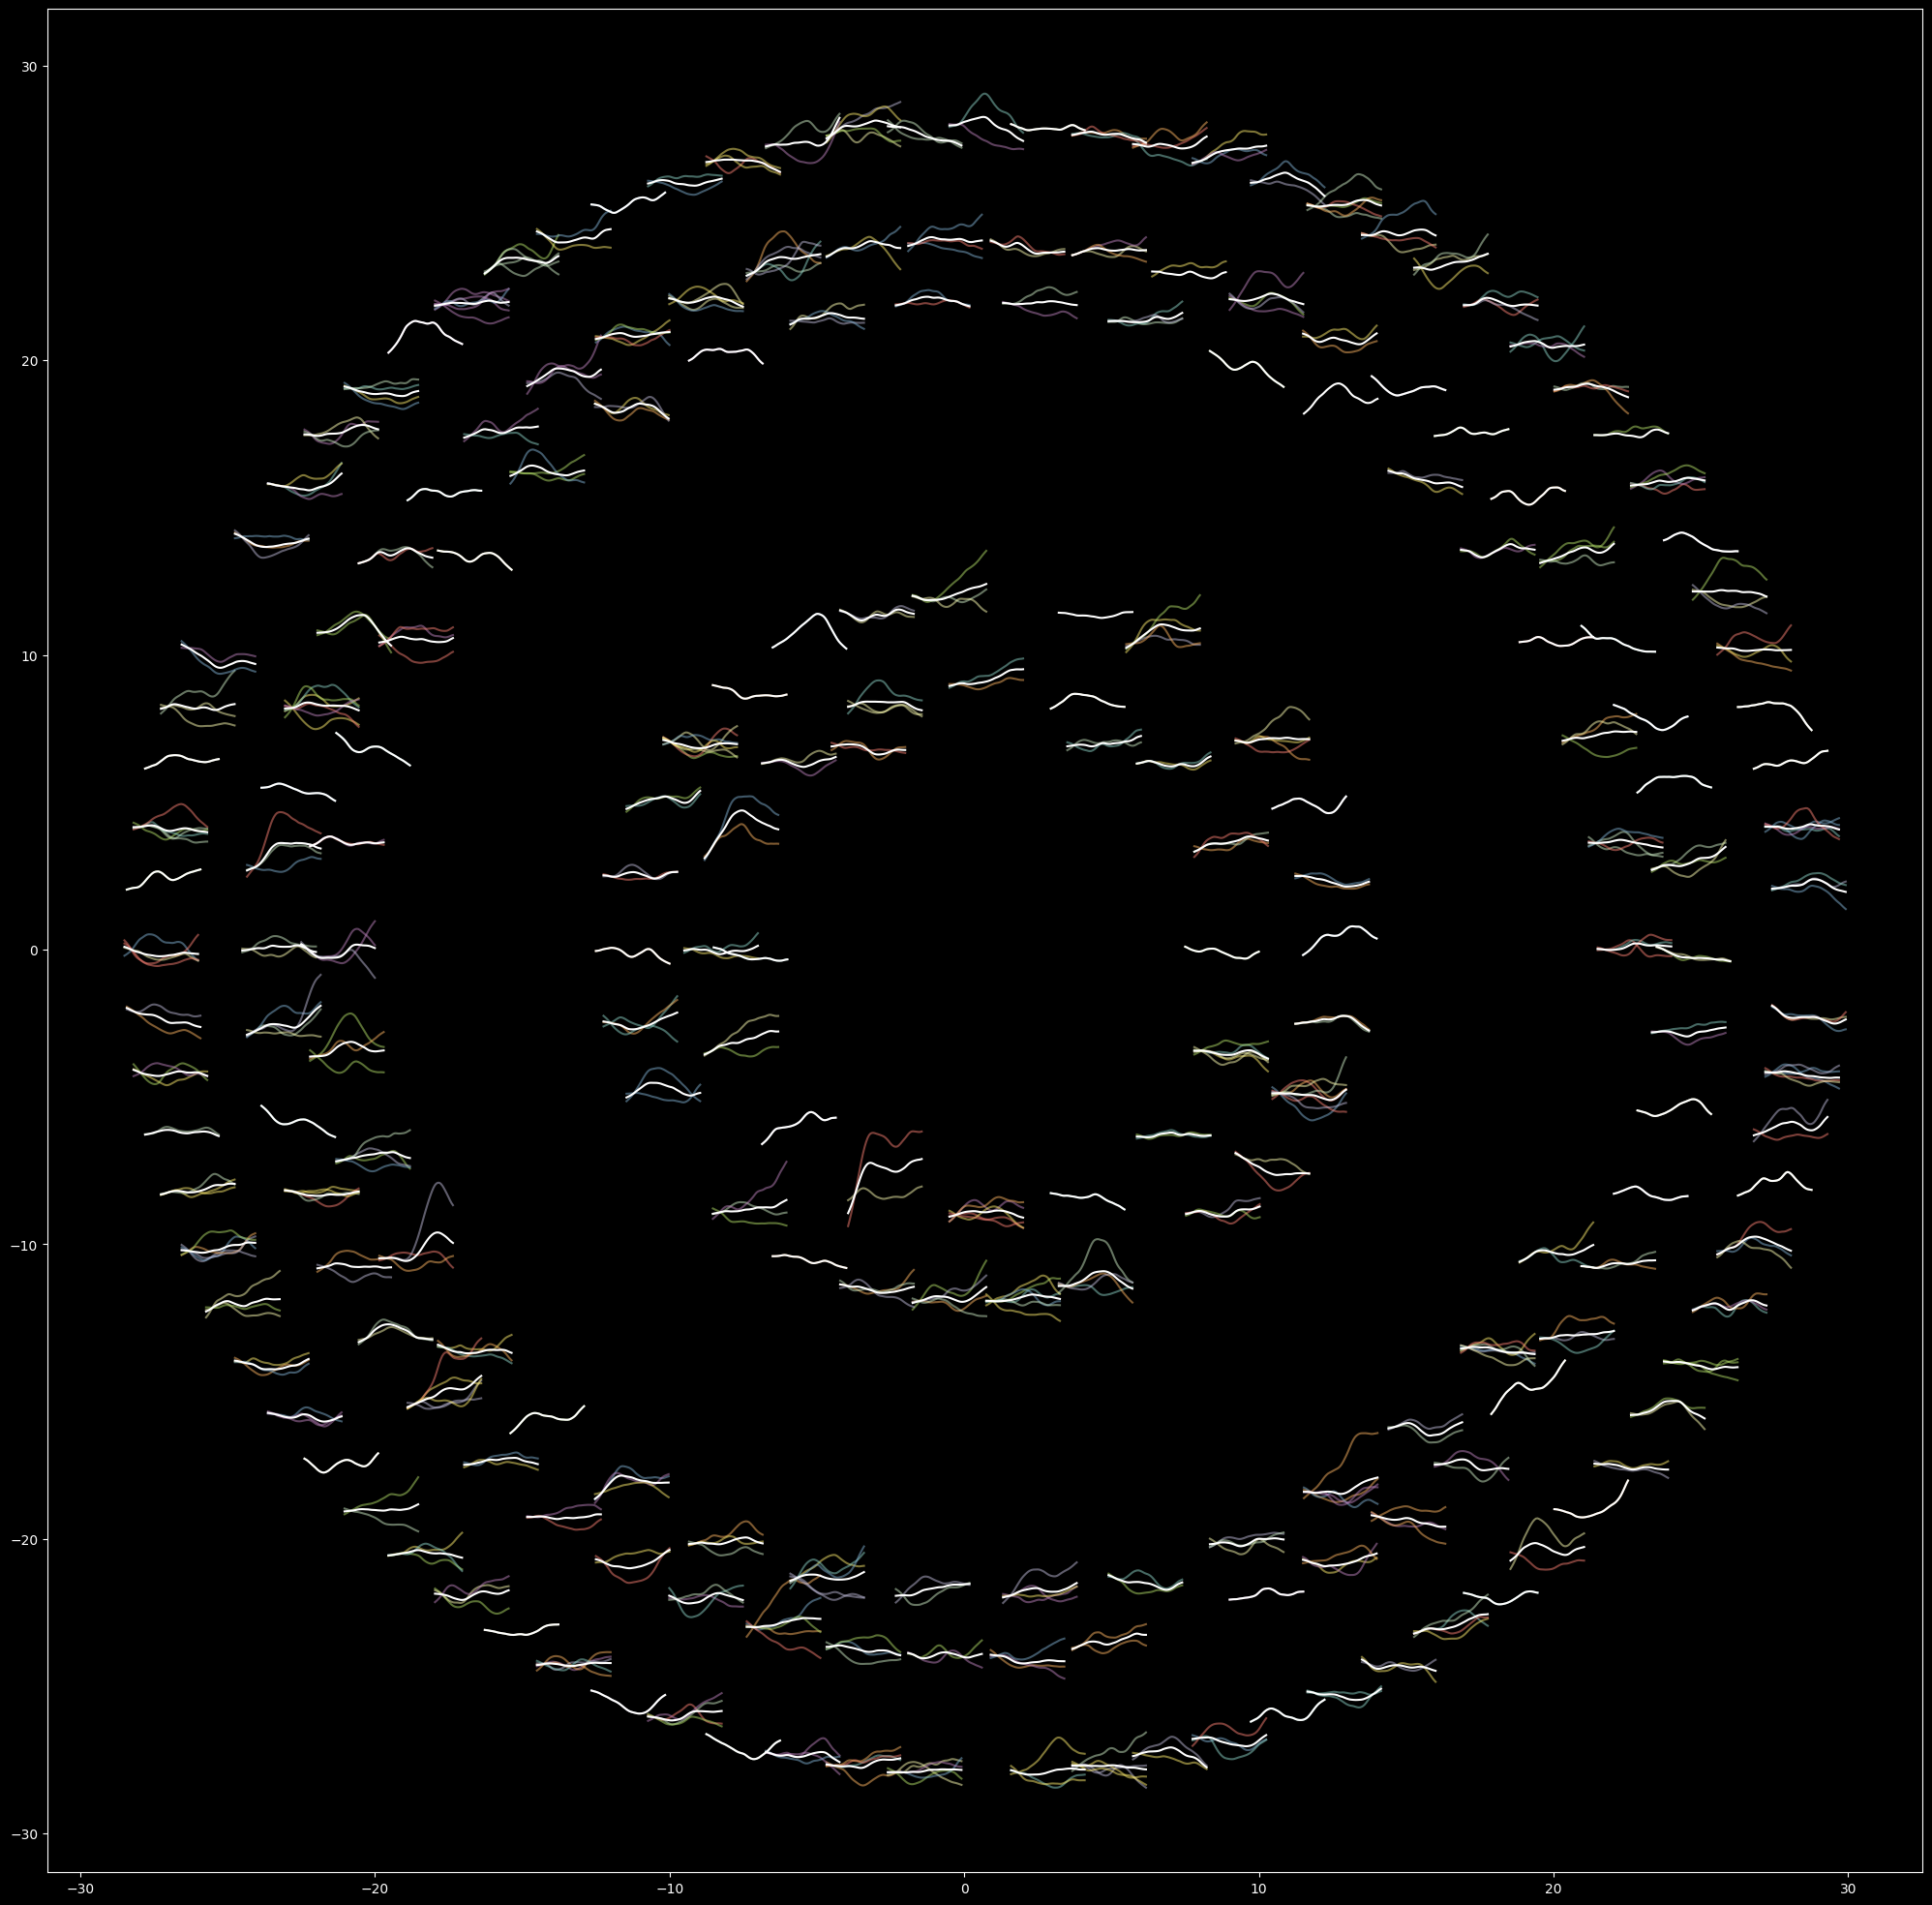

In [335]:
roi = 125
ri = resp_s[:,roi]
cxyi = cxy[~np.any(np.isnan(ri), axis=1),:]
ri = ri[~np.any(np.isnan(ri), axis=1)]


cxyi = np.round(cxyi*100)/100
u,ui = np.unique(cxyi, axis=0, return_inverse=True)

plt.figure(figsize=(25,25))
for i in range(550):
    plt.plot(2*xn_s + cxyi[i,0], 2*ri[i] + cxyi[i,1], alpha=.5)

plt.axis('equal')


for i,(x,y) in enumerate(u):
    plt.plot(2*xn_s + x, 2*ri[ui==i].mean(axis=0) + y, c='w')


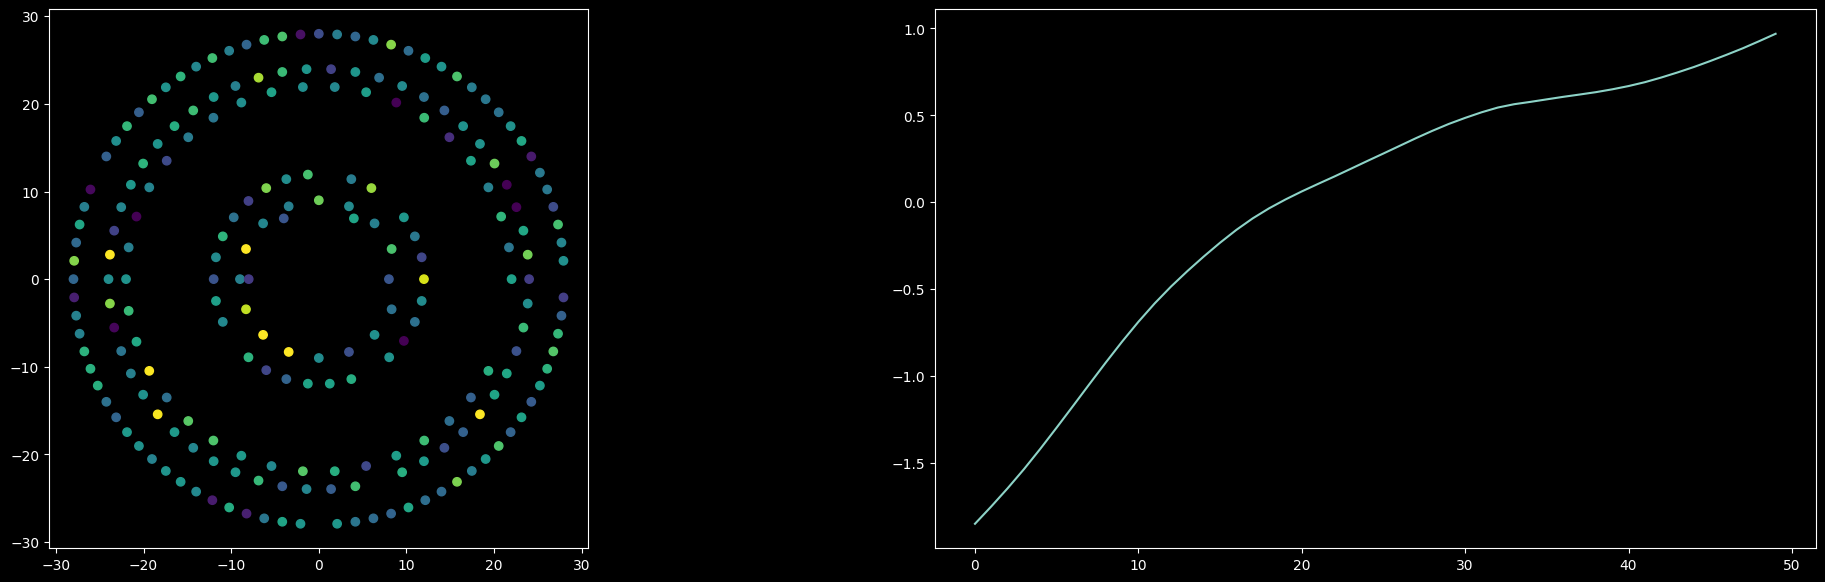

In [336]:
# ri.shape
pca = PCA(3)
pcs = pca.fit_transform(np.asarray([ri[ui==i].mean(axis=0) for i in range(len(u))]).T)
# low,hi = np.percentile(pcs[:,0], [2,98])


# pcr = np.asarray([np.nanmean(pcs[ui == i,0]) for i in range(len(u))])
# pcr = np.asarray([np.nanmean(pca.components_[0,ui == i]) for i in range(len(u))])
pcr = pca.components_[0]
low, hi = np.percentile(pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), [2,98])
_,axs = plt.subplots(1,2,figsize=(25,7))

axs[0].scatter(*u.T, c=pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), vmin = low, vmax=hi)
axs[0].axis('square')
axs[1].plot(pcs[:,0] * np.sign(pcr[np.argmax(np.abs(pcr))]))
# pca.components_.shape

Text(0.5, 1.0, 'RF map')

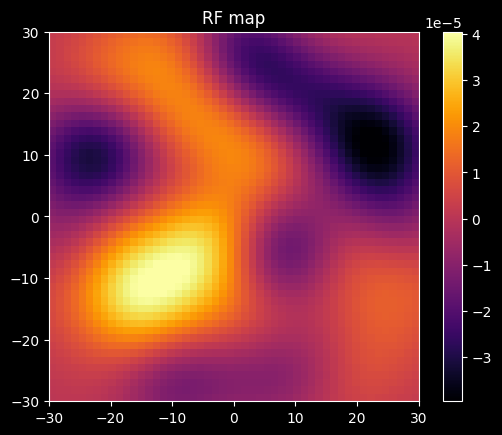

In [337]:
null = gaussian_kde(u.T, weights=np.ones(len(u))/len(u))
nZ = null.evaluate([X.flatten(), Y.flatten()])
# low,hi = np.percentile(pca.components_[0], [2,98])
# w = np.clip(pca.components_[0], low, hi) - low #plot 1st component?
# w /= w.sum()
# kern = gaussian_kde(cxyi.T, weights = w)#, bw_method=.1)
# w = np.clip(pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), low, hi) - low
# w = (pcr - pcr.mean()) / pcr.std()


w = pcr * np.sign(pcr[np.argmax(np.abs(pcr))])
low,hi = np.percentile(w, [2,98])
w = np.clip(w, low, hi) - low
# w = w - w.min()
w /= w.sum()
kern = gaussian_kde(u.T, weights = w)

X,Y = np.meshgrid(np.linspace(-30,30,50), np.linspace(-30,30,50))
Z = kern.evaluate([X.flatten(), Y.flatten()])
plt.imshow((Z-nZ).reshape(X.shape), origin='lower', extent=[-30,30,-30,30], cmap='inferno')

# plt.clim((Z-nZ).reshape(X.shape)[5:-5,5:-5].min(), (Z-nZ).reshape(X.shape)[5:-5,5:-5].max())
plt.clim((kern.evaluate(u.T) - null.evaluate(u.T)).min(), (kern.evaluate(u.T) - null.evaluate(u.T)).max())
# plt.axis('off')
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.colorbar()
plt.title('RF map')

# plt.scatter(*u.T, c=pcr * np.sign(pcr[np.argmax(np.abs(pcr))]), vmin=low, vmax=hi)

In [239]:
kern.evaluate(u.T).min()

0.00022726240332832283

C:\Users\zfj\AppData\Local\Temp\ipykernel_9140\3516058587.py:11: RuntimeWarning: Mean of empty slice.
  mri = np.asarray([ri[(ui==i) & (np.arange(len(ui))<550)].mean(axis=0) for i in range(len(u))])
c:\Users\zfj\anaconda3\envs\func_img\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


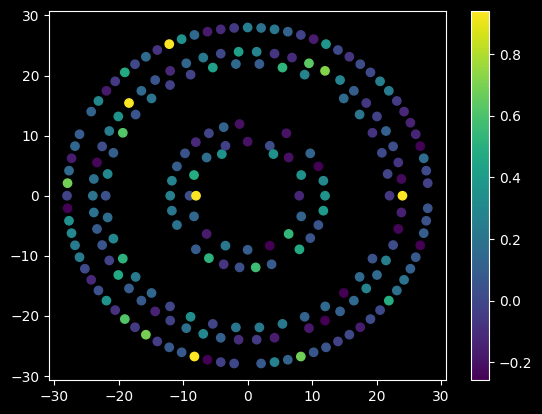

In [191]:
roi = 5
ri = resp_s[:,roi]
cxyi = cxy[~np.any(np.isnan(ri), axis=1),:]
ri = ri[~np.any(np.isnan(ri), axis=1)]


cxyi = np.round(cxyi*100)/100
u,ui = np.unique(cxyi, axis=0, return_inverse=True)


mri = np.asarray([ri[(ui==i) & (np.arange(len(ui))<550)].mean(axis=0) for i in range(len(u))])
us = u[~np.any(np.isnan(mri), axis=1)]
mri = mri[~np.any(np.isnan(mri), axis=1)]

t = mri.mean(axis=1)
# t = np.sqrt((mri**2).mean(axis=1))


low,hi = np.percentile(t, [2,98])
plt.scatter(*us.T, c=t)
plt.colorbar()
plt.clim(low,hi)


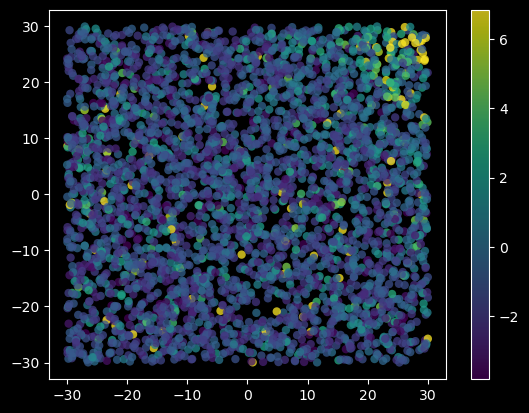

In [105]:
# plt.fill_between(np.array([*thetas,thetas[0]])+np.pi,np.array([*dv[roi], dv[roi,0]]), color='w')
# dv[roi]

# dv[roi].mean()

plt.scatter(cxyi[:,0], cxyi[:,1], c=pcs[:,-1], alpha=.75, edgecolor='none', vmin=hi, vmax=low)
plt.colorbar()

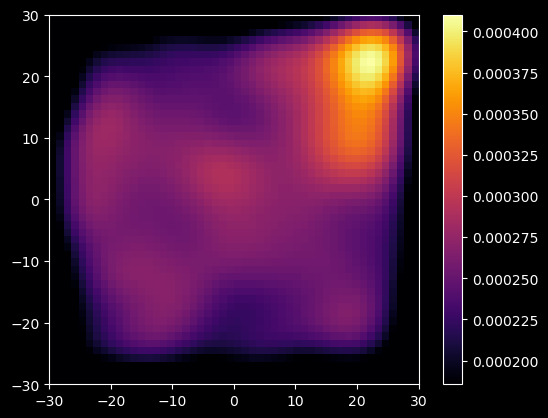

In [114]:
low,hi = np.percentile(pcs[:,-1], [2,98])

w = np.clip(pcs[:,-1], low, hi) - low
w /= w.sum()
kern = gaussian_kde(cxyi.T, weights = w)#, bw_method=.1)
X,Y = np.meshgrid(np.linspace(-30,30,50), np.linspace(-30,30,50))
Z = kern.evaluate([X.flatten(), Y.flatten()])
plt.imshow(Z.reshape(X.shape), origin='lower', extent=[-30,30,-30,30], cmap='inferno')
plt.clim(Z.reshape(X.shape)[5:-5,5:-5].min(), Z.reshape(X.shape)[5:-5,5:-5].max())
plt.colorbar()